# __Identification of the DFN Connected Structure and Core DFN using DFN.Lab__

### Problem Statement

In fracture networks, some fractures contribute little or nothing to the overall flow. These fractures belong to unconnected clusters or dead-end structures that do not influence the connected hydraulic system. Removing these structures from the DFN before solving the flow problem helps optimize simulations and reduce computational costs.

In this tutorial, we will show how to identify and remove these unconnected structures from a DFN, ensuring that only the connected Core DFN is used in the flow simulation. The Core DFN is the subset of fractures within a discrete fracture network that are directly or indirectly connected to system boundaries, contributing to significant flow, with isolated dead-end paths excluded.

<center>
<div>
<img src="https://gitlab.com/fractorylab/dfnlab/-/raw/master/Tutorials/img/backbone.PNG" width="800"/>
</div>
<br>
The process of DFN Core DFN extraction is based on a graph-theoretical approach, where each fracture is represented as a node, and connections between fractures form edges in the graph. 
</center>


### Theoretical Background

A Discrete Fracture Network (DFN) often contains several **clusters**—groups of connected fractures that are not connected to other clusters. These clusters may include fractures that are isolated or part of dead-end pathways, contributing nothing to the overall flow.

To optimize the model and ensure accurate flow simulations, it is essential to remove clusters that are not connected to any **hydraulic boundary condition**. Keeping only the connected Core DFN allows the model to focus on the active part of the network, avoiding unnecessary computational complexity.

The connected structure and Core DFN are identified using a graph representation of the fracture system, where fractures are nodes, and connections between them are edges.


### What Will You Learn?

In this tutorial, you will learn how to:
- Identify the different connected and unconnected clusters in a DFN using graph theory.
- Select and extract only the connected clusters from the DFN, a critical step before solving flow simulations.
- Optimize your DFN model by excluding fractures that do not contribute to fluid flow.


### DFN.Lab Model

The identification of the connected structure and backbone in DFN.Lab is based on a **graph representation** of the system. Each fracture is treated as a node, and the connections between fractures (based on spatial proximity or shared boundaries) form the edges of the graph.

Before identifying the core DFN, it is necessary to have boundary conditions defined on the system (as discussed in ["Tutorial 8"](008-Flow_boundary_condition.ipynb)). These boundary conditions determine which clusters are connected to the hydraulic system and should be retained in the core DFN.

To perform the analysis, we will use the `Analysis` module in DFN.Lab, which provides tools for cluster identification and core DFN extraction.


In [1]:
# Import the Analysis module, which provides tools for identifying connected structures and the core DFN
import dfnlab.Analysis as analysis

---

## Example 1: Core DFN Identification in Permeameter Conditions

In this example, we will identify the clusters within the Discrete Fracture Network (DFN) using a graph-based approach. By identifying clusters, we can distinguish the fractures that are connected and contribute to fluid flow. This step is important before performing flow simulations, as it allows us to focus on the **core DFN**—the connected structure that interacts with the hydraulic boundary conditions.

In [2]:
import dfnlab.Fractures as dfn
import dfnlab.Domains as dom
import dfnlab.System as sys
import dfnlab.IO as io
import os

# Initialize the DFN system
system = sys.System()

# Build a cubic domain with side length 100 centered at [0, 0, 0]
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=100.)  # L1 is the side length of the cubic domain
system.setDomain(domain)

# Create a Discrete Fracture Network (DFN) and load it from the file
fnet = dfn.DFN()
io.load_DFN_file(fnet, os.getcwd() + '/sources/dfnConnectedStructures.disk', format="disk")  # Load fractures from disk

# Set the DFN in the system and build the full system
system.setDFN(fnet)
system.build()


Then, we apply permeameter conditions in the y direction.

In [3]:
import dfnlab.FlowBoundaryConditions as bc
import numpy as np

bc.FlowBoundaryCondition.setPermeameter(domain=domain, deltahead=10, direction=np.array([0,1,0]))

#### Clusters identification

The function _identifyClusters_ identify clusters and assigns an index to each one of them. These indices are also automatically assigned to the cluster fractures.  

In [4]:
# Initialize the analyser to perform connected structure analysis on the system
analyser = analysis.Analyser(system)

# Identify the clusters within the DFN and tag them with the identifier "clusterId"
analyser.identifyClusters("clusterId")

# Print the number of fractures in the entire DFN (including connected and unconnected structures)
print('Number of fractures in the complete DFN: ' + str(fnet.numFractures()))

# Plot the DFN and color-code the fractures based on their cluster membership
from sources.functions import plot_dfn
plot_dfn(system, "clusterId")


Number of fractures in the complete DFN: 4982


#### Selection of the connected clusters

The function *keepConnectedClusters* is responsible for selecting clusters that are connected to at least two boundary conditions, with the exception of no-flow conditions. The function then generates and returns a new system based on these selected clusters.

When a boundary condition is specified, the function uses this information to check if a cluster connects two hydraulically active boundaries. Hydraulically active boundaries are those with imposed flow (excluding no-flow conditions) or boundaries with imposed heads of different values.

In [5]:
# Extract the connected clusters
cluster = analyser.keepConnectedClusters()

# Print the number of fractures in the core DFN (only the connected fractures)
print('Number of fractures in the connected DFN: ' + str(cluster.getDFN().numFractures()))

# Plot the core DFN, highlighting the connected fractures
plot_dfn(cluster, "clusterId")


Number of fractures in the connected DFN: 882


If you use the `overwrite=True` option with the `keepConnectedClusters()` function as follows:

```python
analyser.keepConnectedClusters(overwrite=True)
```

It will result in the system being overwritten. Specifically, only fractures within connected clusters will be retained in the Discrete Fracture Network (DFN), while the fractures belonging to disconnected clusters will be removed. This option proves particularly useful for large DFNs as it helps save both time and memory resources during the analysis process.


__________________

## Example 2: Backbone identification with boundary conditions on two wells

This example is similar to the previous one, except that flow boundary conditions are only applied on two wells.

We begin by initializing the system with a cubic domain and importing a Discrete Fracture Network (DFN) from a disk file. Then, we define two vertical wells at different locations within the domain, representing boreholes where flow boundary conditions will be applied.

In [6]:
# Initialize the DFN system
system = sys.System()

# Build a cubic domain with side length 100 centered at [0, 0, 0]
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=100.)  # L1 is the side length of the cubic domain
system.setDomain(domain)

# Load a Discrete Fracture Network (DFN) from a disk file
fnet = dfn.DFN()
io.load_DFN_file(fnet, os.getcwd() + '/sources/dfnConnectedStructures.disk', format="disk")

# Set the DFN in the system
system.setDFN(fnet)

# Define two vertical wells
well1 = dom.Well1D(point1=[0, -20, 50], point2=[0, -20, -50])  # Well 1 is located at y = -20
well2 = dom.Well1D(point1=[0, +20, 50], point2=[0, +20, -50])  # Well 2 is located at y = +20

# Add the wells to the system
system.addGeometry(well1)
system.addGeometry(well2)

# Finalize the system setup
system.build()


Next, we apply different hydraulic heads (pressures) to the two wells to simulate fluid flow between them. The pressure difference will drive fluid from the well with higher pressure to the well with lower pressure, influencing the connected fractures.

In [7]:
# Apply a hydraulic head of 10 m to Well 1 (representing higher pressure)
bc.FlowBoundaryCondition.setHead(well1, head=10)

# Apply a hydraulic head of -10 m to Well 2 (representing lower pressure)
bc.FlowBoundaryCondition.setHead(well2, head=-10)


As in the previous example, we will identify the clusters of connected fractures within the Discrete Fracture Network (DFN). Our goal is to isolate the fractures that form the **core DFN**—those connected between the two wells. These fractures represent the pathways through which fluid will flow based on the hydraulic boundary conditions applied to the wells.

In [8]:
# Initialize the analyser to perform connected structure analysis on the system
analyser = analysis.Analyser(system)

# Identify the clusters within the DFN and tag them with the identifier "clusterId"
analyser.identifyClusters("clusterId")

# Plot the DFN and the associated geometries (wells) with color-coding based on cluster membership
from sources.functions import plot_dfn_and_geometries
plot_dfn_and_geometries(system, "clusterId")

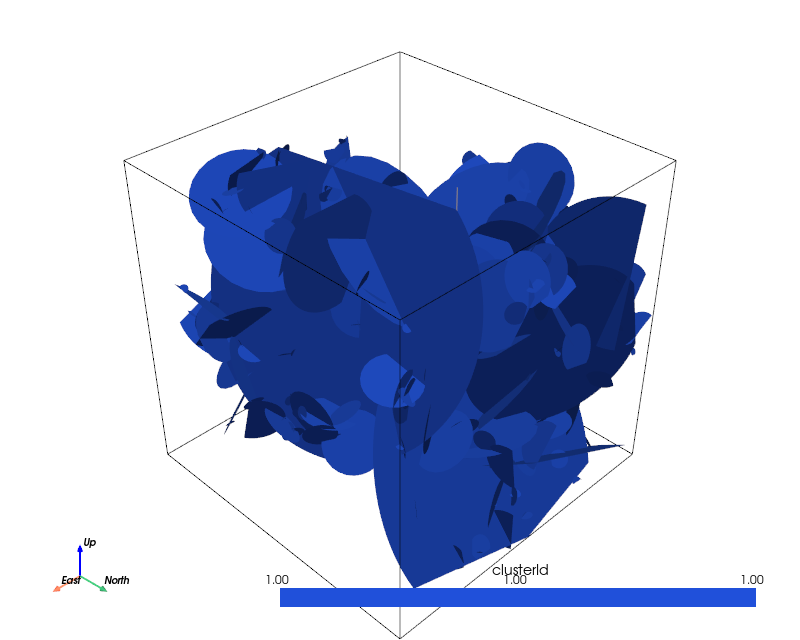

In [9]:
# Extract the Core DFN, i.e., connected clusters minus dead ends.
cluster = analyser.keepCore()

# Plot the core DFN and geometries, highlighting the connected fractures 
plot_dfn_and_geometries(cluster,"clusterId")